In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from portfolio import Portfolio
%matplotlib inline 

## read in data
ret_df_raw= pd.read_excel( io= 'Data/cipc data1.xlsx', sheetname= 'Data_Input', index_col=0)

ret_df= ret_df_raw[['US_RE', 
                   'US_PE',
                   'US_CORP',
                   'SP500',
                   'Rusell2000',
                   'EAFE',
                   'EM']]
                   #'USGOVT10Y']]
ret_df_cov= ret_df.cov()

UniverseProperty= {}

from sklearn.covariance import LedoitWolf
LW= LedoitWolf( ).fit(ret_df)
LW_alpha= LW.shrinkage_

LW_cov= pd.DataFrame(LW.covariance_)*4
LW_cov.index= ret_df_cov.index
LW_cov.columns= ret_df_cov.columns
LW_vol= np.sqrt(np.diag(LW_cov))
LW_corr= pd.DataFrame( np.dot( np.dot( np.diag(1/ LW_vol), LW_cov), np.diag(1/LW_vol)) , 
                      index= LW_cov.index, columns= LW_cov.columns)
CMA_passive_geo= np.array( [7, 8.8, 2.75, 7.21, 8.06, 7.07, 8.03 ])/100
CMA_active_geo= CMA_passive_geo+ np.array( [0,0, 0.5, 1,1,1,1])/100
CMA_passive_arith= CMA_passive_geo+ 0.5* LW_vol**2
LW_cov_active= LW_cov+ np.diag([0, 0, 4, 9,9,9,9])/10000
LW_vol_active= np.sqrt(np.diag(LW_cov_active))
CMA_active_arith= CMA_active_geo+ 0.5* LW_vol_active**2

# the asset universe properties
UniverseProperty['asset_name']= LW_cov.index.tolist()
UniverseProperty['asset_count']= LW_cov.shape[0]
UniverseProperty['LW_cov']= LW_cov
UniverseProperty['LW_vol']= LW_vol
UniverseProperty['LW_corr']= LW_corr
UniverseProperty['CMA_active_geo']= CMA_active_geo
UniverseProperty['CMA_active_arith']= CMA_active_arith
UniverseProperty['LW_cov_active']= LW_cov_active
UniverseProperty['LW_vol_active']= LW_vol_active


# Portfolios

portfolios= {}
portfolios['EqualWeights']= Portfolio(asset_ret= UniverseProperty['CMA_active_geo'], 
                                      asset_cov= UniverseProperty['LW_cov_active'], 
                                      weight= [1/UniverseProperty['asset_count']]* UniverseProperty['asset_count'])

tmp= np.array([0.14,0.29,0.05,0.24,0.03,0.21,0.05])
tmp= tmp/ np.sum(tmp)
portfolios['Peer']= Portfolio( asset_ret= UniverseProperty['CMA_active_geo'],
                             asset_cov= UniverseProperty['LW_cov_active'], 
                             weight= tmp)


# solve ERC

def temp_ERC_func(w, sigma):
    A= np.diag( w)
    B= np.diag( np.dot( sigma, w))
    C= np.diag( np.dot( A, B))/ np.dot( np.dot( w, sigma), w)- np.ones( w.size )* 1/ w.size
    return np.dot( C, C)

from scipy.optimize import minimize 

ERC_opt_res= minimize( temp_ERC_func, 
                 x0= portfolios['EqualWeights'].weight ,
                 args= LW_cov,
                 method= 'Powell',
                 options= {'disp': True},
                 tol= 1e-16)

weight_erc = ERC_opt_res.x/ np.sum( ERC_opt_res.x)

# ERC portfolio
portfolios['ERC']= Portfolio( asset_ret= UniverseProperty['CMA_active_geo'],
                            asset_cov= UniverseProperty['LW_cov_active'],
                            weight= weight_erc)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 1281


In [47]:
pd.DataFrame([CMA_passive_geo, 
              UniverseProperty['CMA_active_geo'],
              UniverseProperty['LW_vol'], 
              UniverseProperty['LW_vol_active']])

,0,1,2,3,4,5,6
0,0.070000,0.088000,0.027500,0.072100,0.080600,0.070700,0.080300
1,0.070000,0.088000,0.032500,0.082100,0.090600,0.080700,0.090300
2,0.099672,0.141276,0.062961,0.152548,0.197004,0.182005,0.252635
3,0.099672,0.141276,0.066061,0.155470,0.199275,0.184461,0.254410


In [3]:
portfolios['Peer'].expected_return

0.080028712871287128

In [4]:
portfolios['Peer'].volatility
portfolios['Peer'].SharpeRatio(risk_free= 1.79/100)

0.50813229286899697

In [5]:
portfolios['EqualWeights'].expected_return

0.07631428571428571

In [6]:
portfolios['EqualWeights'].SharpeRatio(risk_free= 1.79/100)

0.47970113549596327

In [7]:
portfolios['ERC'].expected_return

0.061166237157224766

In [8]:
portfolios['ERC'].SharpeRatio(1.79/100)

0.56189205685468546

In [9]:
43/77

0.5584415584415584

In [10]:
pd.DataFrame(portfolios['ERC'].weight)

,0
0,0.206808
1,0.105522
2,0.403146
3,0.085036
4,0.067863
5,0.074384
6,0.057241


In [48]:
portfolios['Peer'].volatility

0.12226877477221214



## Frontier Construction 


In [11]:

def frontier_obj(w, sigma):
    return (np.dot(  np.dot( w, sigma), w)* .5)

def frontier_obj_der( w, sigma): 
    return (np.dot( w, sigma))


frontier_cons0= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)-1] ) ,
          'jac': lambda w: np.array( [1]*w.size)}

frontier_uncons={}

for target_ret in np.linspace(0.045, 0.1, 100 ): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['CMA_active_arith'])- target_ret,
                'jac': lambda w: UniverseProperty['CMA_active_arith']} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    
    # unconstrained opt
    MV_opt_1= minimize( frontier_obj, 
                    x0= portfolios['EqualWeights'].weight, 
                    args= UniverseProperty['LW_cov_active'], 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter': 1000},
                    constraints= cons, 
                    bounds= [[0, None]]* UniverseProperty['asset_count'],
                    tol= 1e-10)  # long only constrain
    
    frontier_uncons[target_ret]= Portfolio( asset_ret= UniverseProperty['CMA_active_geo'],
                                         asset_cov= UniverseProperty['LW_cov_active'],
                                         weight= MV_opt_1.x)
    




C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0014577770818944482
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0014577770818944482
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0014577770818944482
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0014577770818944482
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0014577770818944482
            Iterations: 23
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003303297747266218
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0033773824501618223
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0034528972648267438
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003529841502101294
            Iterations: 28
            Function evaluations: 29
            Gradient evaluations: 28
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003608214227803333
            Iterations: 28
       

In [12]:
frontier_uncons_NoCorp={}



for target_ret in np.linspace(0.07, 0.1, 100): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['CMA_active_arith'])- target_ret,
                'jac': lambda w: UniverseProperty['CMA_active_arith']} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    initial_guess= np.ones(UniverseProperty['asset_count'])* 1/UniverseProperty['asset_count']
    initial_guess[2]=0
    # unconstrained opt
    MV_opt_2= minimize( frontier_obj, 
                    x0= initial_guess, 
                    args= UniverseProperty['LW_cov_active'], 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter':1000},
                    constraints= cons, 
                    bounds= [[0, None], [0, None], [0, 1e-15]]+ [[0, None]]* ( UniverseProperty['asset_count']- 3),
                    tol= 1e-8)  # long only constrain
    
    frontier_uncons_NoCorp[target_ret]= Portfolio( asset_ret= UniverseProperty['CMA_active_geo'],
                                         asset_cov= UniverseProperty['LW_cov_active'],
                                         weight= MV_opt_2.x)
    




C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Fu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.004363167989505652
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.004399071359981933
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.004437206345568815
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.004477570578338226
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.004520161162530899
            Iterations: 25
         

In [13]:
frontier_cons= {}

for target_ret in np.linspace(0.06, 0.095, 100 ): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['CMA_active_arith'])- target_ret,
                'jac': lambda w: UniverseProperty['CMA_active_arith']} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    # constrained opt 
    MV_opt_3= minimize( frontier_obj, 
                    x0= portfolios['EqualWeights'].weight, 
                    args= UniverseProperty['LW_cov_active'], 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter':1000},
                    constraints= cons, 
                    bounds= [[0,0.3]]* UniverseProperty['asset_count'],
                    tol= 1e-12)  # long only+ concentration constrain
    
    frontier_cons[target_ret]=   Portfolio( asset_ret= UniverseProperty['CMA_active_geo'], 
                                        asset_cov= UniverseProperty['LW_cov_active'],
                                        weight= MV_opt_3.x)
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003927460019674653
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003987888426103522
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.004049085114078486
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0041110500835995194
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.004173783334666651
            Iterations: 22
        

In [14]:
frontier_cons_NoCorp= {}

for target_ret in np.linspace(0.07, 0.1, 100 ): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['CMA_active_arith'])- target_ret,
                'jac': lambda w: UniverseProperty['CMA_active_arith']} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    # constrained opt 
    initial_guess= np.ones(UniverseProperty['asset_count'])* 1/UniverseProperty['asset_count']
    initial_guess[2]=0
    MV_opt_4= minimize( frontier_obj, 
                    x0= initial_guess, 
                    args= UniverseProperty['LW_cov_active'], 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter': 1000},
                    constraints= cons, 
                    bounds= [[0,0.3], [0, 0.3], [0, 1e-15]]+ [[0, 0.3]]* ( UniverseProperty['asset_count']-3) ,
                    tol= 1e-12)  # long only+ concentration constrain
    
    frontier_cons_NoCorp[target_ret]=   Portfolio( asset_ret= UniverseProperty['CMA_active_geo'], 
                                        asset_cov= UniverseProperty['LW_cov_active'],
                                        weight= MV_opt_4.x)
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
         

            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current

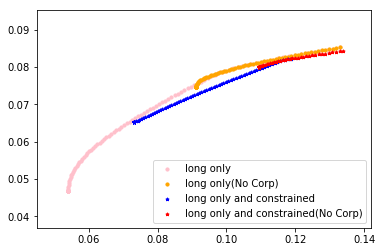

In [15]:
fig= plt.figure()

frontier_uncons_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_uncons.values()]
frontier_uncons_pair.sort(key= lambda x: x[0])
plt.scatter(x= [x[1] for x in frontier_uncons_pair], y= [x[0] for x in frontier_uncons_pair], 
            marker='o', c= 'pink', s=10, label= 'long only')

frontier_uncons_NoCorp_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_uncons_NoCorp.values()]
frontier_uncons_NoCorp_pair.sort(key= lambda x : x[0])
plt.scatter( x= [x[1] for x in frontier_uncons_NoCorp_pair], y = [x[0] for x in frontier_uncons_NoCorp_pair], 
           marker= 'o', c= 'orange', s=10, label= 'long only(No Corp)')


frontier_cons_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_cons.values()]
frontier_cons_pair.sort(key= lambda x : x[0])
plt.scatter(x= [x[1] for x in frontier_cons_pair], y= [x[0] for x in frontier_cons_pair], 
            marker= '*', c= 'blue' , s=10, label= 'long only and constrained')

frontier_cons_NoCorp_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_cons_NoCorp.values()]
frontier_cons_NoCorp_pair.sort(key= lambda x: x[0])
plt.scatter(x= [x[1] for x in frontier_cons_NoCorp_pair], y= [x[0] for x in frontier_cons_NoCorp_pair], 
           marker= '*', c= 'red', s=10, label= 'long only and constrained(No Corp)')
plt.legend()

## Peer Implied Return 


In [46]:
risk_free= 179/10000
gamma= 3.5

UniverseProperty['impliedExpectedReturn_peer_arith']= portfolios['Peer'].implied_ExpectedReturn(gamma= gamma, risk_free= risk_free)
UniverseProperty['impliedExpectedReturn_peer_geo']= UniverseProperty['impliedExpectedReturn_peer_arith']- .5* np.diag(UniverseProperty['LW_cov'])

pd.DataFrame(UniverseProperty['impliedExpectedReturn_peer_geo']).T

,0,1,2,3,4,5,6
0,0.030963,0.059415,0.019873,0.066431,0.070149,0.070369,0.068093


In [17]:
np.array(UniverseProperty['impliedExpectedReturn_peer_arith'] )

array([ 0.0359304 ,  0.06939446,  0.02185507,  0.07806678,  0.0895547 ,
        0.08693194,  0.10000493])

## Combined Return (BL) and Frontier 


In [18]:
from blacklitterman import naive_BlackLitterman

In [19]:
#Apply BL to arithmatic expected return 

prior_ExpectedReturn= UniverseProperty['impliedExpectedReturn_peer_arith']
prior_cov= UniverseProperty['LW_cov_active']
tau= 0.05
prior_risk= UniverseProperty['LW_cov']* tau

views_weight= np.identity(UniverseProperty['asset_count'])
views_expectedReturn= UniverseProperty['CMA_active_arith']
views_risk = UniverseProperty['LW_cov_active']* 2*tau


arithBL= naive_BlackLitterman( prior_ExpectedReturn= prior_ExpectedReturn, prior_uncertainty= prior_risk, prior_cov= prior_cov, 
                         views_weight= views_weight, views_return= views_expectedReturn, views_uncertainty= views_risk)

UniverseProperty['arithBL_peer_CMAactive']= arithBL
# Note: the prior, view and post are arithmatic 
# To convert the aithmatic post expected return to geometric, deduct half post return variance. 


In [20]:
arithBL.post_ExpectedReturn- .5* np.diag( arithBL.post_cov) # post geometric expected return 

array([ 0.04380985,  0.06861074,  0.02357064,  0.07104906,  0.07605534,
        0.07312406,  0.07412406])

In [50]:
pd.DataFrame(arithBL.arith2geo())

,0
0,0.043810
1,0.068611
2,0.023571
3,0.071049
4,0.076055
5,0.073124
6,0.074124


#### Frontier based on BL post Expected Return

In [22]:
frontier_BLuncons={}

for target_ret in np.linspace(0.045, 0.1, 100 ): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn)- target_ret,
                'jac': lambda w: UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    
    # unconstrained opt
    MV_opt_5= minimize( frontier_obj, 
                    x0= portfolios['EqualWeights'].weight, 
                    args= UniverseProperty['arithBL_peer_CMAactive'].post_cov, 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter': 1000},
                    constraints= cons, 
                    bounds= [[0, None]]* UniverseProperty['asset_count'],
                    tol= 1e-10)  # long only constrain
    
    frontier_BLuncons[target_ret]= Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].arith2geo(),
                                         asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov,
                                         weight= MV_opt_5.x)
    




C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0018061111084892532
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0018438935502451395
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0018837359702019404
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0019256384121274677
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0019696008111688397
            Iterations: 23
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005377041216749039
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005503329625779399
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005631622160882155
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00576191882319456
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005894219613636917
            Iterations: 30
          

In [23]:
frontier_BLuncons_NoCorp={}


for target_ret in np.linspace(0.07, 0.1, 100): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn)- target_ret,
                'jac': lambda w: UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    initial_guess= np.ones(UniverseProperty['asset_count'])* 1/UniverseProperty['asset_count']
    initial_guess[2]=0
    # unconstrained opt
    MV_opt_6= minimize( frontier_obj, 
                    x0= initial_guess, 
                    args= UniverseProperty['arithBL_peer_CMAactive'].post_cov, 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter':1000},
                    constraints= cons, 
                    bounds= [[0, None], [0, None], [0, 1e-15]]+ [[0, None]]* ( UniverseProperty['asset_count']- 3),
                    tol= 1e-8)  # long only constrain
    
    frontier_BLuncons_NoCorp[target_ret]= Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].arith2geo(),
                                         asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov,
                                         weight= MV_opt_6.x)
    




C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0055505959473478965
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005612169271008836
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005675397476558232
            Iterations: 13
            Function evaluations: 13
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005739679536866314
            Iterations: 13
            Function evaluations: 13
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005805445264733835
            Iterations: 13
        

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009280010421621647
            Iterations: 11
            Function evaluations: 11
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00939700032839981
            Iterations: 11
            Function evaluations: 11
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009515300650489493
            Iterations: 11
            Function evaluations: 11
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009634913041547134
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009755834292887615
            Iterations: 10
          

            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.01874752547851592
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.01902571630214931
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.019312355628200134
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.019611253274249132
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.01992240339936225
  

In [24]:
frontier_BLcons= {}

for target_ret in np.linspace(0.06, 0.095, 100 ): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn)- target_ret,
                'jac': lambda w: UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    # constrained opt 
    MV_opt_7= minimize( frontier_obj, 
                    x0= portfolios['EqualWeights'].weight, 
                    args= UniverseProperty['arithBL_peer_CMAactive'].post_cov, 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter':1000},
                    constraints= cons, 
                    bounds= [[0,0.3]]* UniverseProperty['asset_count'],
                    tol= 1e-12)  # long only+ concentration constrain
    
    frontier_BLcons[target_ret]=   Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].arith2geo(), 
                                        asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov,
                                        weight= MV_opt_7.x)
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0035367698829103776
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003595222330470245
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003654486391746533
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0037145619725133055
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0037754491811689
            Iterations: 25
         

            Current function value: 0.006898102835007779
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0069989732178093
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0071016467346596175
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007206123386208559
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007312403171685916
            Iterations: 29
            Function evaluations: 29
            Gradient evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.014395969863994156
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0146305962624639
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.014871497410691705
            Iterations: 14
            Function evaluations: 14
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.015119145770158535
            Iterations: 14
            Function evaluations: 14
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.015373541340864359
            Iterations: 14
           

In [25]:
frontier_BLcons_NoCorp= {}

for target_ret in np.linspace(0.07, 0.1, 100 ): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn)- target_ret,
                'jac': lambda w: UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    # constrained opt 
    initial_guess= np.ones(UniverseProperty['asset_count'])* 1/UniverseProperty['asset_count']
    initial_guess[2]=0
    MV_opt_8= minimize( frontier_obj, 
                    x0= initial_guess, 
                    args= UniverseProperty['arithBL_peer_CMAactive'].post_cov, 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter': 1000},
                    constraints= cons, 
                    bounds= [[0,0.3], [0, 0.3], [0, 1e-15]]+ [[0, 0.3]]* ( UniverseProperty['asset_count']-3) ,
                    tol= 1e-12)  # long only+ concentration constrain
    
    frontier_BLcons_NoCorp[target_ret]=   Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].arith2geo(), 
                                        asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov,
                                        weight= MV_opt_8.x)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0061986921585903895
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0061986921585903895
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0061986921585903895
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0061986921585903895
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0061986921585903895
            Iterations: 16
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.01040405831421701
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.010533683469284138
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.010664633376073776
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.010796908034585943
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.010930507444820629
            Iterations: 19
          

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.017104545848404262
            Iterations: 11
            Function evaluations: 42
            Gradient evaluations: 7
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 0.01702767363626406
            Iterations: 17
            Function evaluations: 117
            Gradient evaluations: 13
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 0.016954447432581565
            Iterations: 34
            Function evaluations: 352
            Gradient evaluations: 34
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 0.016884614805973596
            Iterations: 21
            Function evaluations: 191
            Gradient evaluations: 21
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 0.017248799926123038
            Iterations: 94
     

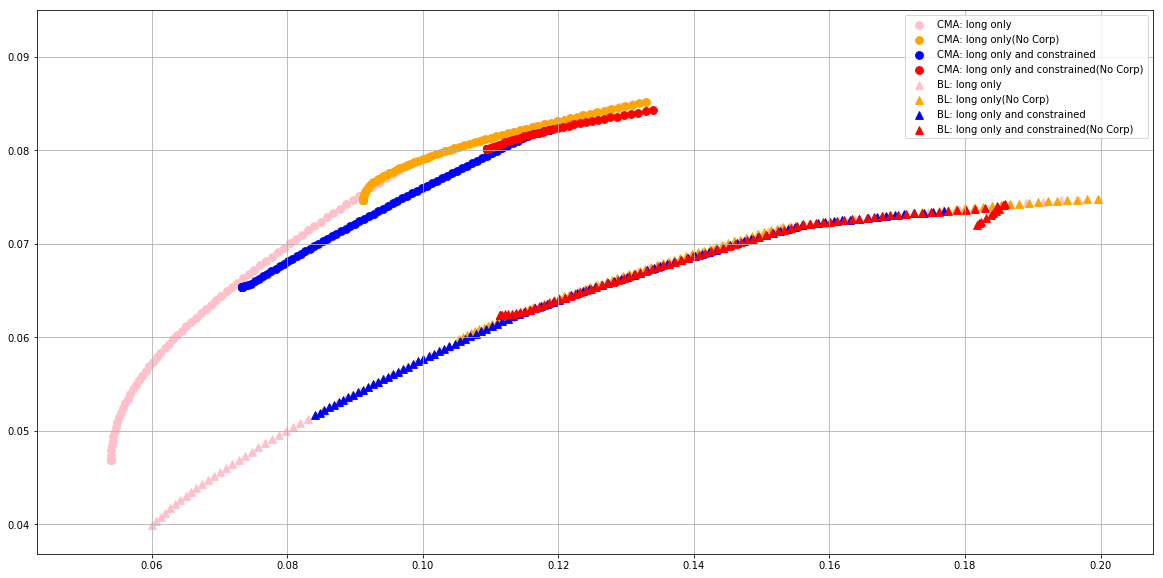

In [26]:
fig= plt.figure(figsize=(20, 10))

plt.scatter(x= [x[1] for x in frontier_uncons_pair], y= [x[0] for x in frontier_uncons_pair], 
            marker='o', c= 'pink', s=60, label= 'CMA: long only')
plt.scatter( x= [x[1] for x in frontier_uncons_NoCorp_pair], y = [x[0] for x in frontier_uncons_NoCorp_pair], 
           marker= 'o', c= 'orange', s=60, label= 'CMA: long only(No Corp)')
plt.scatter(x= [x[1] for x in frontier_cons_pair], y= [x[0] for x in frontier_cons_pair], 
            marker= 'o', c= 'blue' , s=60, label= 'CMA: long only and constrained')
plt.scatter(x= [x[1] for x in frontier_cons_NoCorp_pair], y= [x[0] for x in frontier_cons_NoCorp_pair], 
           marker= 'o', c= 'red', s=60, label= 'CMA: long only and constrained(No Corp)')


frontier_BLuncons_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_BLuncons.values()]
frontier_uncons_pair.sort(key= lambda x: x[0])
plt.scatter(x= [x[1] for x in frontier_BLuncons_pair], y= [x[0] for x in frontier_BLuncons_pair], 
            marker='^', c= 'pink', s=60, label= 'BL: long only')

frontier_BLuncons_NoCorp_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_BLuncons_NoCorp.values()]
frontier_BLuncons_NoCorp_pair.sort(key= lambda x : x[0])
plt.scatter( x= [x[1] for x in frontier_BLuncons_NoCorp_pair], y = [x[0] for x in frontier_BLuncons_NoCorp_pair], 
           marker= '^', c= 'orange', s=60, label= 'BL: long only(No Corp)')


frontier_BLcons_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_BLcons.values()]
frontier_BLcons_pair.sort(key= lambda x : x[0])
plt.scatter(x= [x[1] for x in frontier_BLcons_pair], y= [x[0] for x in frontier_BLcons_pair], 
            marker= '^', c= 'blue' , s=60, label= 'BL: long only and constrained')

frontier_BLcons_NoCorp_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_BLcons_NoCorp.values()]
frontier_BLcons_NoCorp_pair.sort(key= lambda x: x[0])
plt.scatter(x= [x[1] for x in frontier_BLcons_NoCorp_pair], y= [x[0] for x in frontier_BLcons_NoCorp_pair], 
           marker= '^', c= 'red', s=60, label= 'BL: long only and constrained(No Corp)')
plt.legend()
plt.grid()

Note: 
1. CMA results are represented by nodes while the BL results are triangles. BL result shifted down relative to CMA since BL post return is lower than CMA active. 

2. Applying BL slacks the concentration constrain (at 30% level)

3. Applying BL makes US Corp less different from other assets, hence insensitive to the NoCorp Constrain. (Kicking out US Corp leads to smooth extension of the frontier and insignificant jump compared to the CMA cases.)

In [116]:
blended_mvo_BL= Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].arith2geo(), 
                         asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov,
                         weight= np.array( [0.228180399, 0.3, 3.41287E-17, 0.169087738, 0.066754889,0.154949295, 0.081027679]))
blended_mvo_pi= Portfolio( asset_ret= UniverseProperty['impliedExpectedReturn_peer_geo'],
                         asset_cov= UniverseProperty['LW_cov_active'],
                         weight= blended_mvo_BL.weight)
blended_mvo_cma= Portfolio( asset_ret=UniverseProperty['CMA_active_geo'],
                           asset_cov= UniverseProperty['LW_cov_active'], 
                           weight= blended_mvo_BL.weight)

peer_BL= Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].arith2geo(),
                  asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov,
                  weight= portfolios['Peer'].weight)
peer_pi= Portfolio( asset_ret= UniverseProperty['impliedExpectedReturn_peer_geo'],
                  asset_cov= UniverseProperty['LW_cov_active'],
                  weight= portfolios['Peer'].weight)
peer_cma= Portfolio( asset_ret= UniverseProperty['CMA_active_geo'],
                   asset_cov= UniverseProperty['LW_cov_active'],
                   weight= peer_BL.weight)

cma_BL= Portfolio( asset_ret= blended_mvo_BL.asset_return,
                 asset_cov= blended_mvo_BL.asset_cov,
                 weight= np.array( [0.3, 0.3, 0, 0.3, 0, 0.1, 0]))
cma_pi= Portfolio( asset_ret= peer_pi.asset_return,
                 asset_cov= peer_pi.asset_cov,
                 weight= cma_BL.weight)
cma_cma= Portfolio( asset_ret= peer_cma.asset_return, 
                  asset_cov= peer_cma.asset_cov,
                  weight= cma_pi.weight)

In [117]:
peer_BL.expected_return

0.064955163370140942

In [118]:
peer_BL.volatility

0.12428132380236374

In [119]:
peer_BL.SharpeRatio(1.79/100)

0.37861813770964986

In [120]:
peer_pi.expected_return

0.058206927946181777

In [121]:
peer_pi.volatility

0.12226877477221214

In [122]:
peer_pi.SharpeRatio(1.79/100)

0.32965839415070575

In [123]:
peer_cma.expected_return

0.080028712871287128

In [124]:
peer_cma.volatility

0.12226877477221214

In [125]:
peer_cma.SharpeRatio(1.79/100)

0.50813229286899697

In [126]:
blended_mvo_BL.expected_return

0.065006983747864081

In [127]:
blended_mvo_BL.volatility

0.12401999923261095

In [128]:
blended_mvo_BL.SharpeRatio(1.79/100)

0.37983376906421834

In [129]:
blended_mvo_pi.expected_return

0.057226273716821437

In [130]:
blended_mvo_pi.volatility

0.12200839926345082

In [131]:
blended_mvo_pi.SharpeRatio(1.79/100)

0.32232431499986186

In [132]:
blended_mvo_cma.expected_return

0.0821239316834

In [133]:
blended_mvo_cma.volatility

0.12200839926345082

In [134]:
blended_mvo_cma.SharpeRatio(1.79/100)

0.52638942950740852

In [135]:
cma_BL.expected_return

0.062353300274537671

In [136]:
cma_BL.volatility

0.11134354187460004

In [137]:
cma_BL.SharpeRatio(1.79/100)

0.39924453206817256

In [138]:
cma_pi.expected_return

0.054079760745890479

In [139]:
cma_pi.volatility

0.10954215777416304

In [140]:
cma_pi.SharpeRatio(1.79/100)

0.33028161468646872

In [141]:
cma_cma.expected_return

0.080099999999999991

In [142]:
cma_cma.volatility

0.10954215777416304

In [143]:
cma_cma.SharpeRatio(1.79/100)

0.56781791836010997

In [78]:
UniverseProperty['LW_corr']

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
US_RE,1.000000,0.296730,0.015200,0.307848,0.313075,0.260839,0.233716
US_PE,0.296730,1.000000,0.011812,0.692243,0.678817,0.611732,0.577800
US_CORP,0.015200,0.011812,1.000000,0.143748,0.079756,0.176276,0.118270
SP500,0.307848,0.692243,0.143748,1.000000,0.840865,0.771825,0.649903
Rusell2000,0.313075,0.678817,0.079756,0.840865,1.000000,0.704161,0.695298
EAFE,0.260839,0.611732,0.176276,0.771825,0.704161,1.000000,0.674103
EM,0.233716,0.577800,0.118270,0.649903,0.695298,0.674103,1.000000


In [79]:
portfolios['EqualWeights'].volatility

0.12177224816007814

## Active Management Optimization


Treat Peer as bechmark, max the benefit from deviation with limited tracking error budget. 

In [27]:

w_b= portfolios['Peer'].weight
expected_return= UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn
cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov
benchmark_portfolio= Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].arith2geo(), 
                               asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov, 
                               weight= portfolios['Peer'].weight)


frontier_activeM= {} # key tracking error, value the optmized portfolio 



def activeMang_obj(w):
    return  -1*np.dot((w- w_b), expected_return )

def activeMang_obj_der( w): 
    return -1* expected_return

activeMang_cons0= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)-1] ) ,
          'jac': lambda w: np.array( [1]*w.size)}

for trackingError in np.linspace(0, .1, 400): 
    activeMang_cons1= {'type': 'ineq',
                      'fun': lambda w: trackingError**2 - np.dot( np.dot( w- w_b, cov), w-w_b),
                      'jac': lambda w: -2* np.dot(cov, w- w_b)}
    
    activeMang_cons= (activeMang_cons0, 
                     activeMang_cons1)
    MV_opt_9= minimize( activeMang_obj, 
                      x0= w_b,
                      jac= activeMang_obj_der,
                      method= 'SLSQP', 
                      options= {'disp': True, 'maxiter': 1000},
                      constraints= activeMang_cons,
                      bounds= [[0, 0.3]]* UniverseProperty['asset_count'],
                      tol= 1e-12)
    frontier_activeM[trackingError]= Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].arith2geo(),
                                               asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov, 
                                               weight= MV_opt_9.x, benchmark_portfolio= benchmark_portfolio)
    
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4.8332856665799196e-12
            Iterations: 112
            Function evaluations: 221
            Gradient evaluations: 112
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9.835394897054612e-05
            Iterations: 26
            Function evaluations: 41
            Gradient evaluations: 26
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.00019670789776518542
            Iterations: 23
            Function evaluations: 35
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.0002950618469327435
            Iterations: 21
            Function evaluations: 33
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.00039341579592502607
            Iteratio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.00555877741313178
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.0056288747656808346
            Iterations: 16
            Function evaluations: 17
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.005698836009316914
            Iterations: 16
            Function evaluations: 17
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.005768667976401135
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.005838377036993031
            Iterations: 16
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.010107734500755479
            Iterations: 15
            Function evaluations: 15
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.010171161435422038
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.010233538823496285
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.010294938957842985
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.010355426652349425
            Iterations: 19
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.01327257286353121
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.013319375821928742
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.013366093519015318
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.013412727720072758
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.013459280138957199
            Iterations: 18
     

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.01584123858876025
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.015884965235662296
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.015928655468783227
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.0159723098113273
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.01601592877421254
            Iterations: 21
        

            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.018166509353929987
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.018206966734396385
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.018247370052554845
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.018287720049721276
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Cur

            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.019174776313502784
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.019174776313502784
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.019174776313502784
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.019174776313502784
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.0191747763135

            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.019174776313502784
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.019174776313502784
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.019174776313502784
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.019174776313502784
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (E

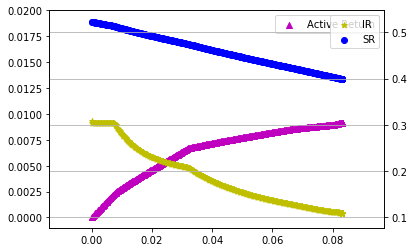

In [28]:
frontier_activeM_pair= [[x.active_expectedReturn, 
                         x.tracking_error, 
                         x.active_expectedReturn/ x.tracking_error,
                         x.SharpeRatio(risk_free= 0) ,
                         x.weight] 
                        for x in frontier_activeM.values()]
frontier_activeM_pair.sort(key= lambda x: x[2], reverse= True)
max_IR= frontier_activeM_pair[0]
frontier_activeM_pair.sort(key= lambda x:x[3], reverse= True)
max_SR= frontier_activeM_pair[0]
frontier_activeM_pair.sort( key= lambda x: x[0])
fig, ax1= plt.subplots()
ax2= ax1.twinx()
ax1.scatter( x= [ x[1] for x in frontier_activeM_pair ], y= [ x[0] for x in frontier_activeM_pair], marker='^', c= 'm', label= 'Active Return') 
ax2.scatter(x= [ x[1] for x in frontier_activeM_pair], y= [x[2] for x in frontier_activeM_pair], marker= '*', c= 'y', label= 'IR')
ax2.scatter( x= [x[1] for x in frontier_activeM_pair], y= [x[3] for x in frontier_activeM_pair], marker= 'o', c= 'b', label= 'SR')
# plt.xlim(- 0.01, 0.035 )
ax1.set_ylim(-1e-3, 0.02)
#plt.ylim( -1e-3, 0.02)
ax1.legend()
ax2.legend()

plt.grid()

In [29]:
benchmark_portfolio.volatility

0.12428132380236374

In [30]:
benchmark_portfolio.expected_return

0.064955163370140942

In [31]:
frontier_activeM_pair.sort(key= lambda x: x[0])
frontier_activeM_pair

[[3.808978230811031e-12,
  1.2378057675891136e-11,
  0.30772018765349712,
  0.52264621409734613,
  array([ 0.13861386,  0.28712871,  0.04950495,  0.23762376,  0.02970297,
          0.20792079,  0.04950495])],
 [7.6326770228898172e-05,
  0.00025062656665699747,
  0.30454381292050925,
  0.52233345196404746,
  array([ 0.13878096,  0.2875812 ,  0.0478196 ,  0.2379904 ,  0.02981087,
          0.20831528,  0.04970169])],
 [0.00015265345785325072,
  0.00050125313285396731,
  0.30454364840393733,
  0.52202131767984072,
  array([ 0.13894803,  0.2880337 ,  0.04613426,  0.23835704,  0.02991877,
          0.20870977,  0.04989844])],
 [0.00022898011004047263,
  0.00075187970000616978,
  0.30454354604678602,
  0.5217098150163304,
  array([ 0.13911513,  0.28848619,  0.04444891,  0.23872367,  0.03002666,
          0.20910426,  0.05009519])],
 [0.00030530667047810157,
  0.0010025062667248013,
  0.30454340347970266,
  0.5213989424224158,
  array([ 0.13928222,  0.28893868,  0.04276356,  0.23909032,  0.03

## Portfolio Construction 


In [32]:
# mean variance opt based over post BL and target peer return 

benchmark_portfolio= Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].arith2geo(), 
                               asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov, 
                               weight= portfolios['Peer'].weight)

base_portfolio_w= sorted( [x for x in frontier_BLcons_pair if x[0]>= 7/100], key= lambda x: x[0]) [0]
base_portfolio= Portfolio(asset_ret= benchmark_portfolio.asset_return,
                         asset_cov= benchmark_portfolio.asset_cov,
                         weight= base_portfolio_w[2], benchmark_portfolio= benchmark_portfolio)



In [33]:
benchmark_portfolio.expected_return

0.064955163370140942

In [34]:
benchmark_portfolio.volatility

0.12428132380236374

In [35]:
benchmark_portfolio.weight

array([ 0.13861386,  0.28712871,  0.04950495,  0.23762376,  0.02970297,
        0.20792079,  0.04950495])

In [36]:
base_portfolio.weight

array([ 0.06587897,  0.3       ,  0.        ,  0.16750796,  0.14351206,
        0.19808016,  0.12502085])

In [37]:
base_portfolio.expected_return

0.070036989782269826

In [38]:
base_portfolio.volatility

0.14634601282081675

In [39]:
base_portfolio.SharpeRatio()

0.47857121921060997

In [40]:
base_portfolio.active_weight

array([-0.07273489,  0.01287129, -0.04950495, -0.0701158 ,  0.11380909,
       -0.00984063,  0.0755159 ])

In [41]:
base_portfolio.DR

1.1940349642689558

In [42]:
benchmark_portfolio.DR

1.2385642471555851

In [43]:
base_portfolio.SharpeRatio()

0.47857121921060997

In [44]:
benchmark_portfolio.SharpeRatio()

0.52264621411206391

The base_portfolio achieves similar return as bechmark with smaller vol. 

In [45]:
# For display purpose 


writter= pd.ExcelWriter('output_wz3.xlsx')
tmp_df1= pd.DataFrame(   [[x[0], x[1]]+ x[2].tolist()  for x in frontier_uncons_pair], 
                      columns= ['ExpectedRet', 'vol']+ UniverseProperty['asset_name']  )
tmp_df2= pd.DataFrame(  [[x[0], x[1]]+ x[2].tolist()  for x in frontier_uncons_NoCorp_pair], 
                     columns=  ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])
tmp_df3= pd.DataFrame(  [[x[0], x[1]]+ x[2].tolist()  for x in frontier_cons_pair], 
                     columns=  ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])
tmp_df4= pd.DataFrame(  [[x[0], x[1]]+ x[2].tolist()  for x in frontier_cons_NoCorp_pair], 
                     columns=  ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])
tmp_df5= pd.DataFrame( [[x[0], x[1]]+ x[2].tolist() for x in frontier_BLuncons_pair], 
                     columns= ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])
tmp_df6= pd.DataFrame( [[x[0], x[1]]+ x[2].tolist() for x in frontier_BLuncons_NoCorp_pair],
                     columns= ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])
tmp_df7= pd.DataFrame( [[x[0], x[1]]+ x[2].tolist() for x in frontier_BLcons_pair], 
                     columns= ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])
tmp_df8= pd.DataFrame( [[x[0], x[1]]+ x[2].tolist() for x in frontier_BLcons_NoCorp_pair],
                     columns= ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])

frontier_activeM_pair.sort(key= lambda x: x[0])
tmp_df9= pd.DataFrame(  [[x[0], x[1], x[2], x[3]]+ x[4].tolist() for x in frontier_activeM_pair], 
                     columns= ['active_ExpReturn', 'trackingError', 'IR', 'SR']+ UniverseProperty['asset_name'])

tmp_df1.to_excel( writter, 'UNCONS')
tmp_df2.to_excel( writter, 'UNCONS_NoCorp')
tmp_df3.to_excel( writter, 'CONS')
tmp_df4.to_excel( writter, 'CONS_NoCorp')
tmp_df5.to_excel( writter, 'BL_UNCONS')
tmp_df6.to_excel( writter, 'BL_UNCONS_NoCorp')
tmp_df7.to_excel( writter, 'BL_CONS')
tmp_df8.to_excel( writter,  'BL_CONS_NoCorp')
tmp_df9.to_excel( writter, 'BL_activeOpt')
writter.save()


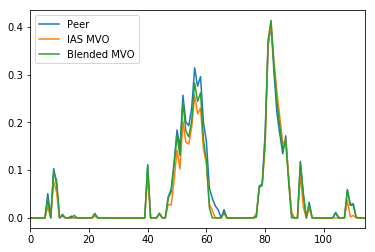

In [96]:
tmp=pd.read_excel( io= 'Data/cipc data1.xlsx', sheetname= 'Sheet4', index= False)
tmp_rollingmax= tmp.rolling(window= tmp.shape[0], min_periods= 1, center= False).max()
tmp_rollingmaxdd= -(tmp-tmp_rollingmax)/tmp_rollingmax
tmp_rollingmaxdd[tmp_rollingmaxdd<0]=0


tmp_rollingmaxdd.plot()

In [98]:
tmp_rollingmaxdd.describe()

,Peer,IAS MVO,Blended MVO
count,115.000000,115.000000,115.000000
mean,0.049610,0.041823,0.046130
std,0.090567,0.083599,0.087714
min,-0.000000,-0.000000,-0.000000
25%,-0.000000,-0.000000,-0.000000
50%,-0.000000,-0.000000,-0.000000
75%,0.059917,0.028696,0.051216
max,0.402530,0.406772,0.413504
